# Challenge Exercise: What insights can homology provide on a weather dataset?

Let's try to get insights from a real dataset our ENSO forecasting model on old data (i.e. early 1900s) from the Cobe SST dataset. There is significantly more uncertainty with this data than there is with newer data, since the advent of remote sensing and data sources has improved.

GOAL OF THIS EXERCISE: you have learned several data visualization/exploration tools. Use the functions on kmeans clustering, simplicial complexes, persistent homology, persistent diagrams, persistent barcodes, turning a time-series signal into a point cloud to try to derive an exploratory analysis of the provided dataset. Your goal is to understand and be able to explain clearly patterns that you observe in the dataset. Some things to try:
-  How would you slice the dataset? In what resolution are you looking for those patterns?
-  What is the connection between the target variable and the predictor variables? Can you derive some of these insights from the data?
- Is there a periodic footprint in the data? Could this be useful?

Dataset summary:
-  Target variable: flow (m3 / sec) – one location
- Predictor Variables: Precipitation (mm) and Temperature (deg C) – 9 locations
- Dates available: 1/1/1957 – 12/26/2016

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import networkx as nx

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances
import gudhi as gd
import plotly.graph_objects as go
from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence

import pickle as pkl

import datetime

In [26]:
df = pd.read_pickle("data.pkl")
df = pd.DataFrame.from_dict(df, orient = "index")
df = df.transpose()
print(type(df["obs_tas"][1]))
print(type(df["obs_pr"][1]))
df


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


,flow,obs_tas,flow_dates,obs_lon_lat,obs_pr,obs_dates
0,1.723781,"[-10.600000381469727, -9.699999809265137, -6.6...",1958-01-04,9.37,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10000000...",1957-01-01
1,0.960882,"[-20.5, -19.100000381469727, -12.0, -17.700000...",1958-01-05,60.23,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20000000...",1957-01-02
2,0.001,"[-23.600000381469727, -22.5, -15.1000003814697...",1958-01-06,None,"[0.10000000149011612, 0.0, 0.30000001192092896...",1957-01-03
3,0.001,"[-16.200000762939453, -16.0, -14.1000003814697...",1958-01-07,None,"[1.0, 0.0, 1.0, 1.100000023841858, 0.899999976...",1957-01-04
4,0.316796,"[-7.900000095367432, -7.800000190734863, -9.5,...",1958-01-08,None,"[9.300000190734863, 8.600000381469727, 8.0, 8....",1957-01-05
...,...,...,...,...,...,...
21541,1.812796,"[-12.5, -11.699999809265137, -8.60000038146972...",2016-12-26,None,"[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27
21542,None,"[-12.5, -11.899999618530273, -9.10000038146972...",NaT,None,"[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28
21543,None,"[-11.899999618530273, -11.399999618530273, -8....",NaT,None,"[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29
21544,None,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...",NaT,None,"[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30


In [56]:
obs_pr = pd.DataFrame()


for i in range(len(df["obs_pr"])):
    df1 = pd.DataFrame(df["obs_pr"][i]).T
    obs_pr = pd.concat([obs_pr, df1])

obs_pr.columns = ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"]
obs_pr


,r1,r2,r3,r4,r5,r6,r7,r8,r9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.1
0,0.1,0.0,0.3,0.1,0.3,0.3,0.4,0.3,0.5
0,1.0,0.0,1.0,1.1,0.9,0.7,0.8,0.4,0.6
0,9.3,8.6,8.0,8.9,8.7,10.2,9.3,10.1,9.7
...,...,...,...,...,...,...,...,...,...
0,2.2,0.1,1.1,1.5,0.1,0.0,0.0,0.0,0.0
0,5.5,4.9,8.3,6.1,3.7,5.0,5.4,0.0,5.1
0,1.8,1.7,2.1,2.7,0.2,0.8,2.2,0.0,0.0
0,4.1,3.5,4.6,5.1,3.5,3.4,3.2,0.0,3.6


In [57]:
obs_tas = pd.DataFrame()


for i in range(len(df["obs_tas"])):
    df1 = pd.DataFrame(df["obs_tas"][i]).T
    obs_tas = pd.concat([obs_tas, df1])

obs_tas.columns = ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"]
obs_tas

,r1,r2,r3,r4,r5,r6,r7,r8,r9
0,-10.600000,-9.7,-6.7,-8.800000,-8.900000,-7.500000,-8.1,-6.5,-5.4
0,-20.500000,-19.1,-12.0,-17.700001,-17.700001,-13.100000,-15.5,-11.8,-9.1
0,-23.600000,-22.5,-15.1,-21.400000,-21.400000,-16.299999,-19.4,-14.6,-12.2
0,-16.200001,-16.0,-14.1,-15.600000,-15.400000,-14.500000,-15.0,-13.8,-11.9
0,-7.900000,-7.8,-9.5,-7.600000,-7.500000,-8.000000,-7.4,-8.6,-8.2
...,...,...,...,...,...,...,...,...,...
0,-12.500000,-11.7,-8.6,-11.000000,-10.900000,-9.200000,-9.7,-8.4,-7.5
0,-12.500000,-11.9,-9.1,-11.400000,-11.200000,-9.800000,-10.6,-8.6,-7.5
0,-11.900000,-11.4,-8.4,-10.800000,-10.800000,-8.600000,-9.3,-7.2,-6.3
0,-7.000000,-6.5,-3.4,-5.900000,-6.100000,-4.800000,-5.0,-3.8,-3.0


In [75]:
obs_tas = obs_tas.reset_index(drop= True)

In [76]:
a = df["obs_dates"]
a

0       1957-01-01
1       1957-01-02
2       1957-01-03
3       1957-01-04
4       1957-01-05
           ...    
21541   2015-12-27
21542   2015-12-28
21543   2015-12-29
21544   2015-12-30
21545   2015-12-31
Name: obs_dates, Length: 21546, dtype: datetime64[ns]

In [77]:
obs_tas["date"] = a
obs_tas

,r1,r2,r3,r4,r5,r6,r7,r8,r9,date
0,-10.600000,-9.7,-6.7,-8.800000,-8.900000,-7.500000,-8.1,-6.5,-5.4,1957-01-01
1,-20.500000,-19.1,-12.0,-17.700001,-17.700001,-13.100000,-15.5,-11.8,-9.1,1957-01-02
2,-23.600000,-22.5,-15.1,-21.400000,-21.400000,-16.299999,-19.4,-14.6,-12.2,1957-01-03
3,-16.200001,-16.0,-14.1,-15.600000,-15.400000,-14.500000,-15.0,-13.8,-11.9,1957-01-04
4,-7.900000,-7.8,-9.5,-7.600000,-7.500000,-8.000000,-7.4,-8.6,-8.2,1957-01-05
...,...,...,...,...,...,...,...,...,...,...
21541,-12.500000,-11.7,-8.6,-11.000000,-10.900000,-9.200000,-9.7,-8.4,-7.5,2015-12-27
21542,-12.500000,-11.9,-9.1,-11.400000,-11.200000,-9.800000,-10.6,-8.6,-7.5,2015-12-28
21543,-11.900000,-11.4,-8.4,-10.800000,-10.800000,-8.600000,-9.3,-7.2,-6.3,2015-12-29
21544,-7.000000,-6.5,-3.4,-5.900000,-6.100000,-4.800000,-5.0,-3.8,-3.0,2015-12-30


In [82]:
obs_pr = obs_pr.reset_index(drop = True)
obs_pr["date"] = a
obs_pr

,r1,r2,r3,r4,r5,r6,r7,r8,r9,date
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,1957-01-01
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.1,1957-01-02
2,0.1,0.0,0.3,0.1,0.3,0.3,0.4,0.3,0.5,1957-01-03
3,1.0,0.0,1.0,1.1,0.9,0.7,0.8,0.4,0.6,1957-01-04
4,9.3,8.6,8.0,8.9,8.7,10.2,9.3,10.1,9.7,1957-01-05
...,...,...,...,...,...,...,...,...,...,...
21541,2.2,0.1,1.1,1.5,0.1,0.0,0.0,0.0,0.0,2015-12-27
21542,5.5,4.9,8.3,6.1,3.7,5.0,5.4,0.0,5.1,2015-12-28
21543,1.8,1.7,2.1,2.7,0.2,0.8,2.2,0.0,0.0,2015-12-29
21544,4.1,3.5,4.6,5.1,3.5,3.4,3.2,0.0,3.6,2015-12-30


In [83]:
obs_pr.to_csv("precipitacion.csv", index = False)
obs_tas.to_csv("temperatura.csv", index = False)

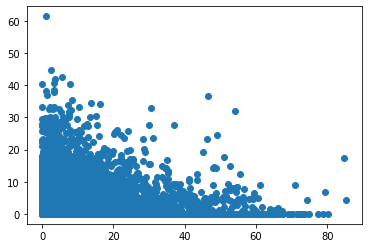

In [88]:
plt.scatter(df["flow"], obs_pr["r1"])